In [75]:
from datasets import get_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
from configs.get_configs import get_config


class DotDict(dict):
    def __getattr__(self, key):
        return self[key]
    def __setattr__(self, key, val):
        if key in self.__dict__:
            self.__dict__[key] = val
        else:
            self[key] = val

In [76]:
import torch
from run_lib import evaluate
torch.cuda.device_count()

1

In [77]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [79]:
%%capture
args = DotDict()
args.conf = "128_tiny"
args.test = False
args.DDP = False
args.workdir = "pfgm_128_tiny"
args.eval_folder = "eval"
args.sampling = True
config = get_config(args)
args.config = config
#args.config.sampling.ode_solver = 'torchdiffeq'
args.config.sampling.ode_solver = 'torchdiffeq' # rk45, improved_euler
args.config.sampling.ckpt_number = 70000
args.config.sampling.N = 50
args.config.sampling.z_max = 25
args.config.eval.num_samples = 32
args.config.eval.batch_size = 32

## Libs for Sampling

In [80]:
import os
import time
import copy
import logging
import numpy as np
# Keep the import below for registering all model definitions
from models import ncsnpp_audio, stablediff, diffwave
import losses
import sampling
from models import utils as mutils
from models.ema import ExponentialMovingAverage
import datasets
import methods
import torch
from torchvision.utils import make_grid, save_image
from utils import save_checkpoint, restore_checkpoint
import wandb
import torch.distributed as dist
import gc
import torchaudio 

In [81]:
config = args.config
workdir = args.workdir
eval_folder = args.eval_folder
eval_dir = os.path.join(workdir, eval_folder)
os.makedirs(eval_dir, exist_ok=True)

# setup logger
gfile_stream = open(os.path.join(args.workdir, 'stdout_eval.txt'), 'w')
handler = logging.StreamHandler(gfile_stream)
formatter = logging.Formatter('%(levelname)s - %(filename)s - %(asctime)s - %(message)s')
handler.setFormatter(formatter)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel('INFO')

# Build data pipeline
if config.eval.enable_loss:
    train_ds, eval_ds, _ = datasets.get_dataset(args, evaluation=True)

# Create data normalizer and its inverse
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)

# Initialize model
net = mutils.create_model(args)
print("Created Model")
optimizer, scheduler = losses.get_optimizer(config, net.parameters())
ema = ExponentialMovingAverage(net.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=net, ema=ema, scheduler=scheduler, step=0)

checkpoint_dir = os.path.join(workdir, "checkpoints")

torch.cuda.empty_cache()
gc.collect()

# Setup methods
if config.training.sde.lower() == 'poisson':
    sde = methods.Poisson(args=args)
    sampling_eps = config.sampling.z_min
    print("--- sampling eps:", sampling_eps)
else:
    raise NotImplementedError(f"Method {config.training.sde} unknown.")


# Wait if the target checkpoint doesn't exist yet
torch.manual_seed(config.seed)
np.random.seed(config.seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

if config.training.sde == 'poisson':
    if config.sampling.ckpt_number > 0:
        ckpt_filename = os.path.join(checkpoint_dir, "checkpoint_{}.pth".format(config.sampling.ckpt_number))
        ckpt_path = os.path.join(checkpoint_dir, f'checkpoint_{config.sampling.ckpt_number}.pth')
    else:
        raise ValueError("Please provide a ckpt_number!")

if not os.path.exists(ckpt_filename):
    print(f"{ckpt_filename} does not exist! Loading from meta-checkpoint")
    ckpt_filename = os.path.join(checkpoint_dir, os.pardir, 'checkpoints-meta', 'checkpoint.pth')
    if not os.path.exists(ckpt_filename):
        print("No checkpoints-meta")

# Wait for 2 additional mins in case the file exists but is not ready for reading
print("Loading from ", ckpt_path)
try:
    state = restore_checkpoint(ckpt_path, state, map_location=config.device)
    print("State Loaded")
except Exception as e:
    print("Loading Failed!")
    print(e)
    time.sleep(60)
    try:
        state = restore_checkpoint(ckpt_path, state, map_location=config.device)
    except Exception as e:
        time.sleep(120)
        state = restore_checkpoint(ckpt_path, state, map_location=config.device)

        
ckpt = config.sampling.ckpt_number
ema.copy_to(net.parameters())

# Build the sampling function when sampling is enabled
if config.eval.enable_sampling:
    sampling_shape = (config.eval.batch_size,
                      config.data.num_channels,
                      config.data.image_height, config.data.image_width)
    sampling_fn = sampling.get_sampling_fn(config, sde, sampling_shape, inverse_scaler, sampling_eps, net)
    
print("DONE!")

BUILDING MODEL...
MODEL BUILT!
Created Model
--- sampling eps: 0.001
Loading from  pfgm_128_tiny/checkpoints/checkpoint_70000.pth
State Loaded
DONE!


In [82]:
import gc
torch.cuda.empty_cache()
gc.collect()

12

In [ ]:
num_sampling_rounds = config.eval.num_samples // config.eval.batch_size + 1
# Directory to save samples. Different for each host to avoid writing conflicts
this_sample_dir = os.path.join(eval_dir, f"ckpt_{ckpt}")
audio_dir = os.path.join(this_sample_dir,f"audio_{ckpt}")
os.makedirs(this_sample_dir, exist_ok=True)
os.makedirs(audio_dir, exist_ok=True)

# torch.backends.cudnn.benchmark=True
net.eval()

print(f"Sampling for {num_sampling_rounds-1} rounds...")
start = time.time()
total_samples = 0
for r in range(num_sampling_rounds):
    samples, n = sampling_fn(net)
    total_samples += samples.shape[0]
    print(r, " ")
stop = time.time()

Sampling for 1 rounds...
0  


In [ ]:
total = stop - start
per_sample = total / total_samples
print("Took: ", total, " seconds for ", total_samples, "\nAverage of ", per_sample)

In [52]:
from librosa.feature.inverse import db_to_power
from librosa.feature.inverse import mel_to_audio

In [53]:
from configs.default_audio_configs import get_mels_128

In [54]:
spec_conf = get_mels_128()
sample_rate = spec_conf.sample_rate
hop_length = spec_conf.hop_length
nfft = spec_conf.nfft

In [26]:
mel_dat = samples
mel_data = mel_dat.squeeze().cpu().numpy()


mel_data = np.clip(mel_data, 0.0, 1.0)
mel_data *= 80
mel_data -= 80

mel_data = db_to_power(mel_data)
audio = mel_to_audio(
    M=mel_data,
    sr=sample_rate,
    n_fft=nfft,
    hop_length=hop_length,
    win_length=hop_length * 4,
    center=True,
    power=1,
    n_iter=32,
    fmin=20,
    fmax=sample_rate / 2.0,
    pad_mode="reflect",
    norm='slaney',
    htk=True
)
audio /= max(audio.max(), -audio.min())

In [55]:
audio = samples.cpu().squeeze().numpy()
print(audio.shape)

(2, 16000)


In [56]:
import IPython.display as ipd
ipd.Audio(audio[1], rate=sample_rate) # load a local WAV file

## Full evaluation pipeline

In [58]:
sr = 16000
mel_args = {
      'sample_rate': sr,
      'win_length': 256 * 4,
      'hop_length': 256,
      'n_fft': 1024,
      'f_min': 20.0,
      'f_max': sr / 2.0,
      'n_mels': 80,
      'power': 1.0,
      'normalized': True,
  }
spectrogram = torchaudio.transforms.MelSpectrogram(**mel_args)
audio, sr = torchaudio.load('SpeechCommands/speech_commands_v0.02/one/0a2b400e_nohash_0.wav')
mel = spectrogram(audio)

In [60]:
start_diff = time.time()
for _ in range(32):
    audio, sample_rate = diffwave_predict(spectrogram, model_dir, fast_sampling=True)
stop_diff = time.time()

In [61]:
print(stop_diff-start_diff)

3.064465045928955


In [15]:
import IPython.display as ipd
ipd.Audio(audio[0].cpu().numpy(), rate=sample_rate) # load a local WAV file

In [146]:
start = time.time()
evaluate(args)
stop = time.time()

Initilaized MEL training dataset.
Initilaized MEL validation dataset.
BUILDING MODEL...
MODEL BUILT!
Created Model
--- sampling eps: 0.001
Loading from  pfgm_128_deep_v2/checkpoints/checkpoint_480000.pth
Sampling for 2 rounds...
sampling -- ckpt: 480000, round: 0
nfe: 0
sample shape: torch.Size([8, 1, 128, 128])
Saving images as raw mel specs.
sampling -- ckpt: 480000, round: 1
nfe: 0
sample shape: torch.Size([8, 1, 128, 128])
Saving images as raw mel specs.


In [147]:
print(stop-start)

93.68240261077881


In [143]:
for i, item in enumerate(trainds):
    if i>1: break
    print(item.max(), item.min())

tensor(0.9909) tensor(-0.9709)
tensor(1.0000) tensor(-0.9427)


5.303516e-05 1.0 0.6378556
speech_commands_v0.02/five/299c14b1_nohash_0.wav


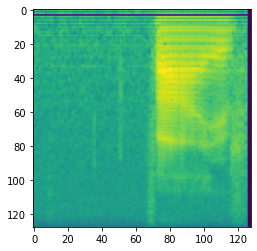

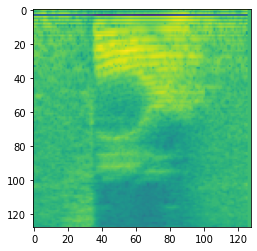

8.7488315e-06 1.0 0.6885094
speech_commands_v0.02/seven/2da58b32_nohash_2.wav


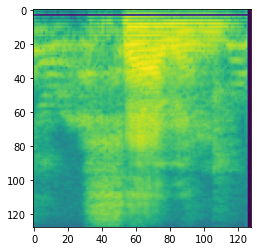

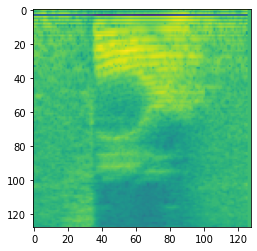

9.149497e-06 1.0 0.64606667
speech_commands_v0.02/six/14775481_nohash_0.wav


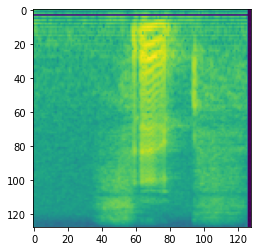

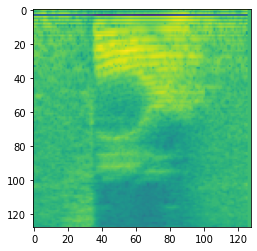

2.414852e-05 1.0 0.5794746
speech_commands_v0.02/five/050170cb_nohash_2.wav


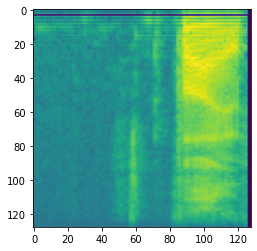

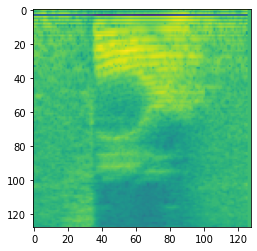

2.4926652e-05 1.0 0.6026093
speech_commands_v0.02/four/9587481f_nohash_0.wav


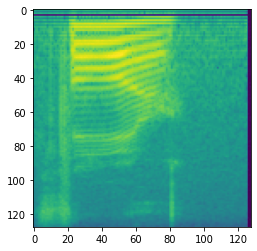

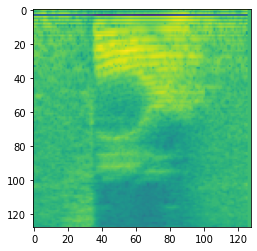

5.3609514e-05 1.0 0.6546959
speech_commands_v0.02/seven/b29f8b23_nohash_4.wav


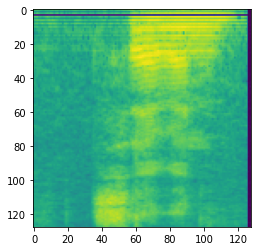

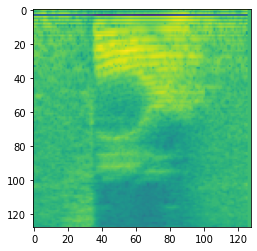

3.4017048e-05 1.0 0.6604657
speech_commands_v0.02/five/ffb86d3c_nohash_0.wav


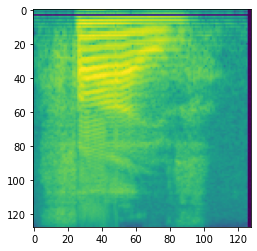

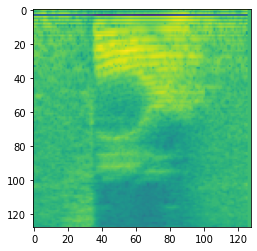

3.7711322e-06 1.0 0.5113603
speech_commands_v0.02/seven/990ebd1f_nohash_0.wav


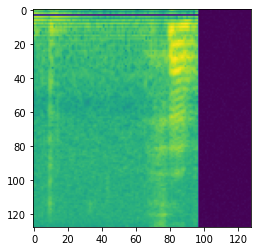

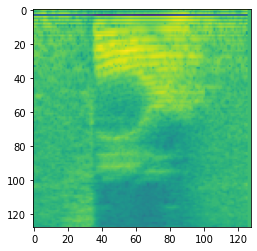

1.3788815e-05 1.0 0.57341266
speech_commands_v0.02/zero/b9515bf3_nohash_1.wav


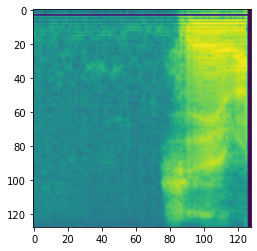

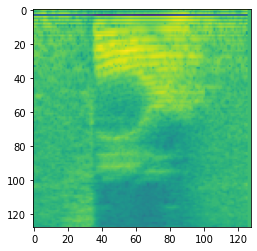

2.4984422e-06 1.0 0.5285512
speech_commands_v0.02/one/ff4ed4f3_nohash_2.wav


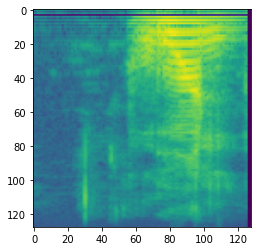

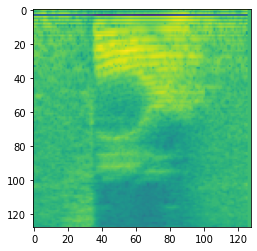

0.0001216339 1.0 0.58640206
speech_commands_v0.02/nine/674ca5ea_nohash_2.wav


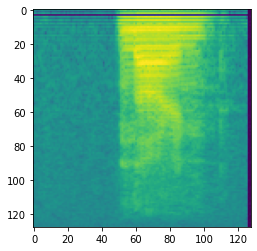

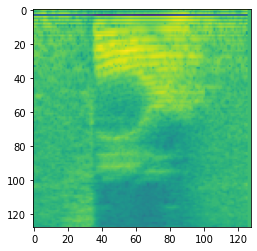

3.3827473e-07 1.0 0.67959225
speech_commands_v0.02/three/29fb33da_nohash_2.wav


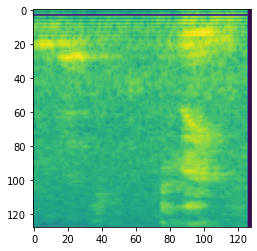

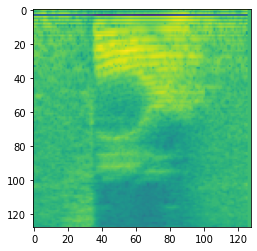

7.188918e-05 1.0 0.6123474
speech_commands_v0.02/seven/be7a5b2d_nohash_1.wav


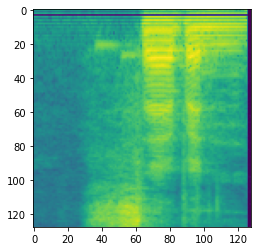

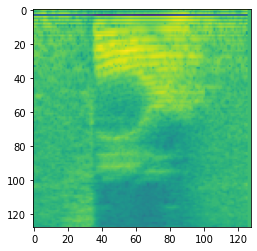

1.2280392e-05 1.0 0.44202578
speech_commands_v0.02/one/e6be0830_nohash_0.wav


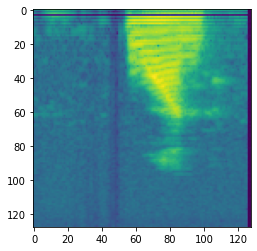

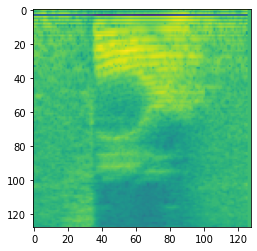

1.234358e-05 1.0 0.6093167
speech_commands_v0.02/six/01bb6a2a_nohash_2.wav


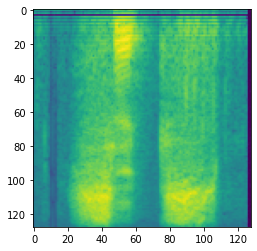

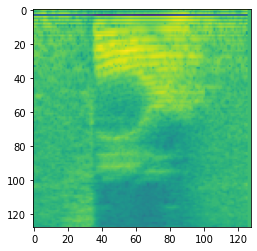

1.1711885e-05 1.0 0.5637418
speech_commands_v0.02/five/6bf5baf3_nohash_0.wav


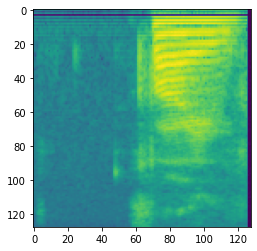

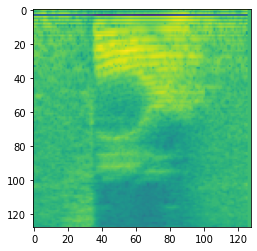

6.407963e-05 1.0 0.5277083
speech_commands_v0.02/two/559bc36a_nohash_2.wav


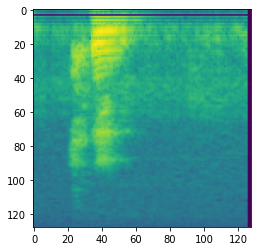

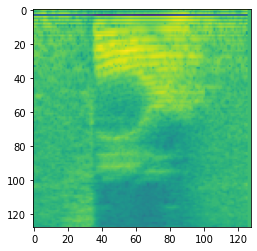

1.1016903e-06 1.0 0.48801467
speech_commands_v0.02/six/39dce8cc_nohash_0.wav


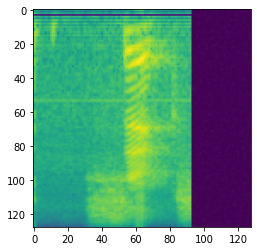

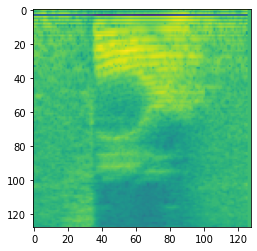

1.46743805e-05 1.0 0.57541317
speech_commands_v0.02/one/fb727898_nohash_3.wav


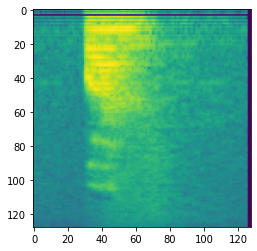

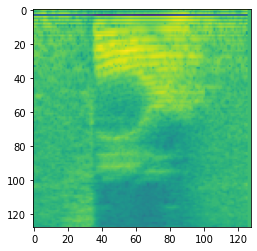

3.074042e-05 1.0 0.58373827
speech_commands_v0.02/two/2e30f9a5_nohash_0.wav


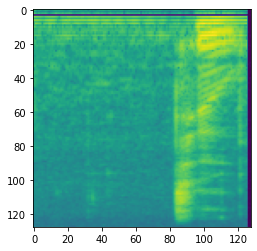

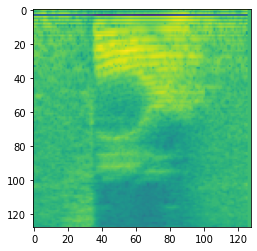

1.6379154e-05 1.0 0.5274006
speech_commands_v0.02/one/61ab8fbc_nohash_0.wav


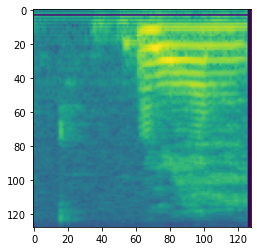

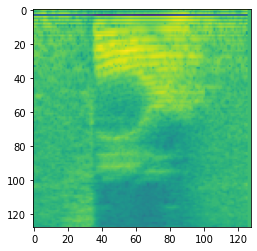

2.5908499e-05 1.0 0.5896466
speech_commands_v0.02/one/1c3f50ad_nohash_0.wav


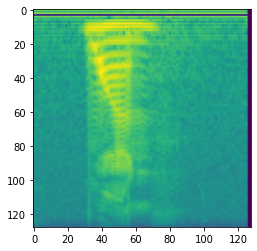

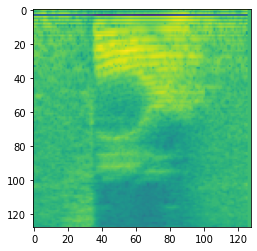

9.2106005e-05 1.0 0.6561508
speech_commands_v0.02/five/8442ea62_nohash_1.wav


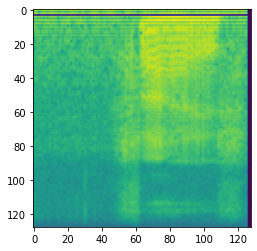

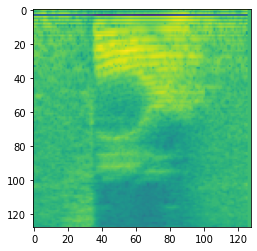

7.079154e-05 1.0 0.6023152
speech_commands_v0.02/seven/ef3367d9_nohash_4.wav


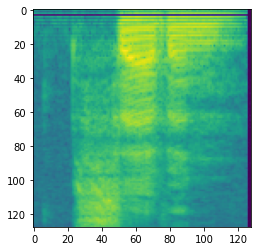

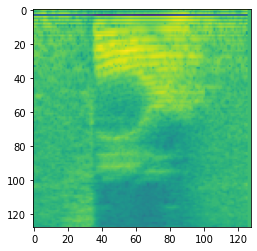

5.9688807e-07 1.0 0.6904071
speech_commands_v0.02/zero/efa16ffd_nohash_0.wav


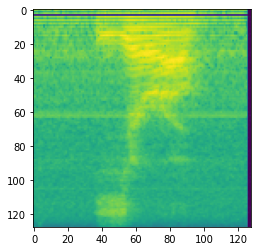

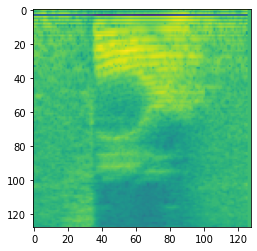

2.229636e-06 1.0 0.53217316
speech_commands_v0.02/two/333d7ddb_nohash_3.wav


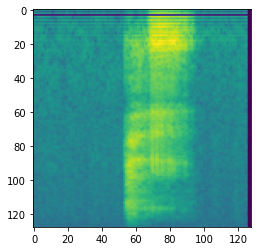

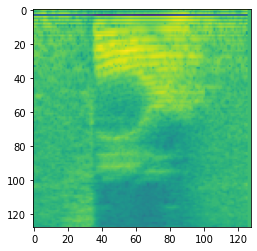

In [62]:
for i, (item, path) in enumerate(trainds):
    if i>25: break
    spec = item[0][0].numpy()
    print(spec.min(), spec.max(), spec.mean())
    print(path[0])
    plt.figure()
    plt.imshow(spec)
    plt.show()
    plt.figure()
    plt.imshow(spec_demean)
    plt.show()

In [10]:
# Calculate norms on CIFAR10 for comparison
import torchvision
cf10 = torchvision.datasets.CIFAR10(root='.', download=True)

norms_2_cf = []
norms_cf = []
for item in tqdm(cf10):
    pic = np.array(item[0]) / 255.0
    norm_2 = np.sqrt(pic.ravel()**2)
    norms_2_cf.append(norm_2)
    norm = pic.ravel()**2
    norms_cf.append(norm)

Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:05<00:00, 8826.68it/s]


0.2873594542857112 0.4733630004850902


In [11]:
norms_cf = np.array(norms_cf)
norms_2_cf = np.array(norms_2_cf)

print(norms_cf.sum())

44138412.17828524


In [18]:
norms_2 = []
norms = []
for batch in tqdm(trainds):
    for item in batch:
        #scale to 0-1
        item += 1
        item /= 2.0
        norm = item.numpy().ravel()**2
        norms.append(norm)
        norm_2 = np.sqrt(item.numpy().ravel()**2)
        norms_2.append(norm_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1215/1215 [03:58<00:00,  5.10it/s]


In [21]:
gc.collect()

2450

In [19]:
norms = np.array(norms)

In [23]:
cfm = norms_cf.mean()
nm = norms.mean()

In [26]:
nm/cfm * 32

28.03440761038546

In [20]:
norms.sum()

156607710.0

In [22]:
156607710 / 44138412

3.548104766433373

In [19]:
print(np.array(norms).mean(), np.array(norms_2).mean())

0.007212365 0.032030698


In [22]:
0.007212365 / .2873594542857112 * 32

0.8031602112193884

In [21]:
.032030698 / .4733630004850902

0.06766624760950005